# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
# import torch
from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.51123313.kevidu/ipykernel_443266/2601860326.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pan

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

In [5]:
# sns.color_palette("colorblind")
# print(sns.color_palette("colorblind").as_hex())

'Bitstream Vera Sans'

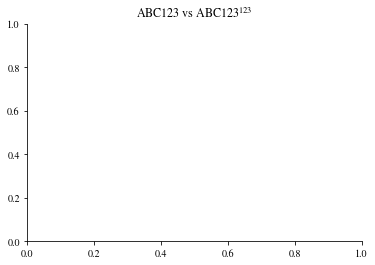

In [6]:
from mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

In [7]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-s8.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

In [8]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-s8.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 8, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAME': 'top_entity_u

In [9]:
# Downloads yago_qec.json from wandb (if not already cached there)
artifact, files = load_artifact_from_wandb(
    f"{DATASET_NAME}-yago_qec",
    save_dir=Path(RAW_DATA_PATH).parent,
)
artifact.name

'YagoECQ-yago_qec:v9'

In [10]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [11]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [12]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID)
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped


In [13]:
# Set random seeds
# torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [14]:
# qid_to_artifact_path = {
#     query_id: add_val_df_to_wandb(
#         yago_qec=yago_qec,
#         **DATASET_KWARGS,
#         QUERY_ID=query_id,
#     )
#     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
#     for query_id in tqdm(query_ids)
# }

In [15]:
# query_ids = list(
#     set(query_ids).difference(
#         [
#             # "http://yago-knowledge.org/resource/studentsCount",
#             # "http://schema.org/numberOfPages",
#             "http://yago-knowledge.org/resource/distanceFromEarth",
#             # "http://schema.org/numberOfEmployees",
#             # "http://schema.org/numberOfEpisodes",
#             # "http://schema.org/numberOfSeasons",
#             # "http://schema.org/humanDevelopmentIndex",
#             "http://schema.org/duns",
#             # "http://schema.org/duration",
#             "http://schema.org/unemploymentRate",
#             "http://yago-knowledge.org/resource/radialVelocity",
#             # "http://schema.org/populationNumber",
#             "http://yago-knowledge.org/resource/luminosity",
#             "http://yago-knowledge.org/resource/parallax",
#             "http://yago-knowledge.org/resource/length",
#             "http://schema.org/elevation",
#             # "http://yago-knowledge.org/resource/sportNumber",
#             "http://yago-knowledge.org/resource/mass",
#         ]
#         # [
#         #     "http://yago-knowledge.org/resource/studentsCount",
#         #     "http://schema.org/numberOfPages",
#         #     "http://yago-knowledge.org/resource/distanceFromEarth",
#         #     "http://schema.org/numberOfEmployees",
#         #     "http://schema.org/numberOfEpisodes",
#         #     "http://schema.org/numberOfSeasons",
#         #     "http://schema.org/humanDevelopmentIndex",
#         #     "http://schema.org/duns",
#         #     "http://schema.org/duration",
#         #     "http://schema.org/unemploymentRate",
#         #     "http://yago-knowledge.org/resource/radialVelocity",
#         #     "http://schema.org/populationNumber",
#         #     "http://yago-knowledge.org/resource/luminosity",
#         #     "http://yago-knowledge.org/resource/parallax",
#         #     "http://yago-knowledge.org/resource/length",
#         #     "http://schema.org/elevation",
#         #     "http://yago-knowledge.org/resource/sportNumber",
#         #     "http://yago-knowledge.org/resource/mass",
#         # ]
#     )
# )
# # qid_to_results_paths = {
# #     query_id: load_val_df_from_wandb(
# #         yago_qec=yago_qec,
# #         **DATASET_KWARGS,
# #         QUERY_ID=query_id,
# #         verbose=False,
# #         overwrite_df=True,
# #     )
# #     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
# #     for query_id in tqdm(query_ids)
# # }

In [16]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    **DATASET_KWARGS,
    QUERY_ID="http://schema.org/actor",
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://schema.org/actor.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object 
 4   contexts               400 non-null    object 
 5   persuasion_scores      400 non-null    object 
 6   persuasion_scores_kl   400 non-null    object 
 7   type                   400 non-null    object 
 8   susceptibility_score   400 non-null    float64
 9   sampled_mr             400 non-null    float64
 10  sampled_answergroups   400 non-null    object 
 11  sampled_outputs        400 non-null    object 
 12  entity_classes         400 non-null    object 
 13  query_type             400 non-null    object 
 14  relev

In [17]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
        verbose=False,
        overwrite_df=False,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

  0%|          | 0/125 [00:00<?, ?it/s]/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
 20%|██        | 25/125 [01:22<04:05,  2.46s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 36%|███▌      | 45/125 [02:28<03:08,  2.36s/it]

Computing val_df_per_qe for http://schema.org/motto.
Unable to find file at data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 53%|█████▎    | 66/125 [03:39<02:43,  2.78s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


100%|██████████| 125/125 [07:24<00:00,  3.55s/it]


In [18]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/motto', 'http://schema.org/url', 'http://schema.org/gtin'}


In [19]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://schema.org/lyricist"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds
323,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Gott erhalte Franz den Kaiser,)",Lorenz Leopold Haschka,[A lyricist for 'Across the Universe' is a Caz...,"[0.29490184783935547, 0.4574427604675293, 1.24...","[0.480533994299495, 0.2994642013147998, 0.6675...",entities,0.815419,{'http://schema.org/CreativeWork': 0.740740740...,open,"[180, 181, 182, 183, 184]"
308,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Amhrán na bhFiann,)",Peadar Kearney,[A lyricist for 'Across the Universe' is a Caz...,"[0.9080157279968262, 0.29494380950927734, 1.37...","[0.6777028330396617, 0.23465810606651763, 0.79...",entities,0.844593,{'http://schema.org/CreativeWork': 0.740740740...,open,"[15, 16, 17, 18, 19]"
346,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Lucy in the Sky with Diamonds,)",John Lennon,[A lyricist for 'Across the Universe' is a Caz...,"[0.5486249923706055, 0.6428766250610352, 1.889...","[0.988235430769374, 0.4358658853149478, 0.8458...",entities,0.902412,{'http://schema.org/CreativeWork': 0.740740740...,open,"[260, 261, 262, 263, 264]"
331,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Take Me Home, Country Roads,)",John Denver,[A lyricist for 'Across the Universe' is a Caz...,"[0.13915395736694336, 0.30098867416381836, 3.8...","[1.0706250568769844, 0.22521980203515946, 1.16...",entities,0.945097,{'http://schema.org/CreativeWork': 0.740740740...,open,"[390, 391, 392, 393, 394]"
334,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Mamma Mia!,)",Benny Andersson,[A lyricist for 'Across the Universe' is a Caz...,"[1.0923986434936523, 1.3014211654663086, 1.594...","[1.4268034372582383, 0.4066025009529771, 0.625...",entities,0.949211,{'http://schema.org/CreativeWork': 0.740740740...,open,"[265, 266, 267, 268, 269]"


In [20]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [21]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

100%|██████████| 122/122 [00:01<00:00, 100.62it/s]


[384, 376, 332, 324, 296, 280, 384, 308, 280, 280, 280, 384, 316, 280, 280, 336, 384, 320, 360, 384, 388, 288, 392, 320, 336, 280, 328, 352, 308, 396, 396, 280, 392, 396, 284, 320, 344, 380, 312, 384, 396, 392, 280, 388, 280, 312, 328, 388, 400, 380, 320, 392, 308, 276, 400, 316, 320, 328, 340, 392, 280, 392, 324, 272, 324, 308, 288, 280, 324, 388, 356, 308, 280, 308, 392, 308, 308, 308, 280, 308, 308, 392, 280, 308, 336, 292, 300, 336, 308, 280, 292, 280, 304, 280, 316, 312, 288, 280, 332, 352, 280, 340, 308, 372, 400, 280, 328, 340, 392, 312, 344, 400, 324, 280, 308, 384, 308, 340, 392, 324, 296, 340]


### Susceptibility Score vs Relation-dependent Entity Degree

In [22]:
QID_TO_ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_predicate_degree_path.json"
with open(QID_TO_ENTITY_DEG_PATH) as f:
    qid_to_entity_degree = json.load(f)

len(qid_to_entity_degree)

127

In [23]:
qid_ent_deg_df = pd.DataFrame(
    [
        (qid, entity_uri, degree)
        for qid, entity_to_degree in qid_to_entity_degree.items()
        for entity_uri, degree in entity_to_degree.items()
    ],
    columns=["q_id", "entity_uri", "qid_ent_degree"],
)

In [24]:
def convert_entity_uri_to_entity(row: pd.Series):
    try:
        q_id = row["q_id"]
        entity_uris = yago_qec[q_id]["entity_uris"]
        eu_index = entity_uris.index(row["entity_uri"])
        entities = yago_qec[q_id]["entities"]

        return entities[eu_index]
    except (KeyError, ValueError):
        return None

In [25]:
qid_ent_deg_df["entity"] = qid_ent_deg_df.apply(convert_entity_uri_to_entity, axis=1)
qid_ent_deg_df = qid_ent_deg_df.dropna()
qid_ent_deg_df["entity"] = qid_ent_deg_df["entity"].apply(lambda x: (x,))
qid_ent_deg_df["qid_ent_degree"] = pd.to_numeric(qid_ent_deg_df["qid_ent_degree"])

In [26]:
val_dfs_all = pd.concat(list(qid_to_val_df_per_qe.values()), axis=0)

In [27]:
val_dfs_with_deg = val_dfs_all.merge(qid_ent_deg_df, on=["q_id", "entity"])
val_dfs_with_deg["log_qid_ent_degree"] = val_dfs_with_deg["qid_ent_degree"].apply(
    np.log
)
val_dfs_with_deg

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,sampled_mr,sampled_answergroups,sampled_outputs,entity_classes,query_type,relevant_context_inds,entity_uri,qid_ent_degree,log_qid_ent_degree
0,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Christmas Carol' is about psychoanalysis.\...,"[0.1553642749786377, 0.22357654571533203, 0.12...","[0.027815370652517164, 0.043836283026991815, 0...",entities,0.043855,0.791583,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","["" Yes.\nQ: Is 'The Great G"", "" Yes.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[90, 91, 92, 93, 94]",http://yago-knowledge.org/resource/Crime_and_P...,2,0.693147
1,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Stranger Things,)",monster,['A Christmas Carol' is about psychoanalysis.\...,"[-0.06708741188049316, 0.09819746017456055, 0....","[0.022833921013827058, 0.04258298997236172, 0....",entities,0.038873,0.373494,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","["" Yes.\nQ: Is 'Stranger Things"", "" No.\nQ: Is...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[335, 336, 337, 338, 339]",http://yago-knowledge.org/resource/Stranger_Th...,3,1.098612
2,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,['A Christmas Carol' is about psychoanalysis.\...,"[0.03029918670654297, 0.14701223373413086, 0.0...","[0.015203277054757696, 0.03643121713720158, 0....",entities,0.030013,0.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","["" No.\nQ: Is 'The Wizard of"", "" No.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[310, 311, 312, 313, 314]",http://yago-knowledge.org/resource/Sleeping_Be...,1,0.000000
3,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,['A Christmas Carol' is about psychoanalysis.\...,"[0.03029918670654297, 0.14701223373413086, 0.0...","[0.015203277054757696, 0.03643121713720158, 0....",entities,0.030013,0.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","["" No.\nQ: Is 'The Wizard of"", "" No.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[310, 311, 312, 313, 314]",http://yago-knowledge.org/resource/Sleeping_Be...,4,1.386294
4,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,(Indiana Jones and the Kingdom of the Crystal ...,Cold War,['A Christmas Carol' is about psychoanalysis.\...,"[-0.11788058280944824, -0.03805828094482422, 0...","[0.02278468065604346, 0.02966140934779633, 0.0...",entities,0.033426,0.180361,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","["" No.\nQ: Is 'The Dark Knight"", "" No.\nQ: Is ...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[155, 156, 157, 158, 159]",http://yago-knowledge.org/resource/Indiana_Jon...,2,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24399,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Kansas,)",Missouri Route 92,[Ambershade is the terminus of Interstate 26.\...,"[1.8289904594421387, 1.2700207233428955, 1.274...","[0.760417918504088, 1.0777539594112768, 0.8013...",entities,1.194973,0.000000,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' California State Route 113.\n\nSee also\n',...",{'http://schema.org/Organization': 0.404761904...,open,"[205, 206, 207, 208, 209, 365]",http://yago-knowledge.org/resource/Kansas,19,2.944439
24400,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(West Virginia,)",Maryland Route 36,[Ambershade is the terminus of Interstate 26.\...,"[1.9239256381988525, 1.413771152496338, 0.8318...","[0.7192163629326621, 1.2228602110285924, 0.590...",entities,1.127610,0.000000,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[' West Virginia Route 113.\n\nSee also\n', ' ...",{'http://schema.org/Organization': 0.404761904...,open,"[227,

In [28]:
from scipy import stats as sst

sst.spearmanr(
    val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"][
        ["log_qid_ent_degree", "susceptibility_score"]
    ]
)

SpearmanrResult(correlation=0.11038955089486904, pvalue=2.147625639574281e-34)

In [29]:
val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"][
    ["log_qid_ent_degree", "susceptibility_score"]
].to_csv(
    os.path.join(analysis_dir, "log_qid_ent_deg_vs_sus_score_open.csv"), index=False
)

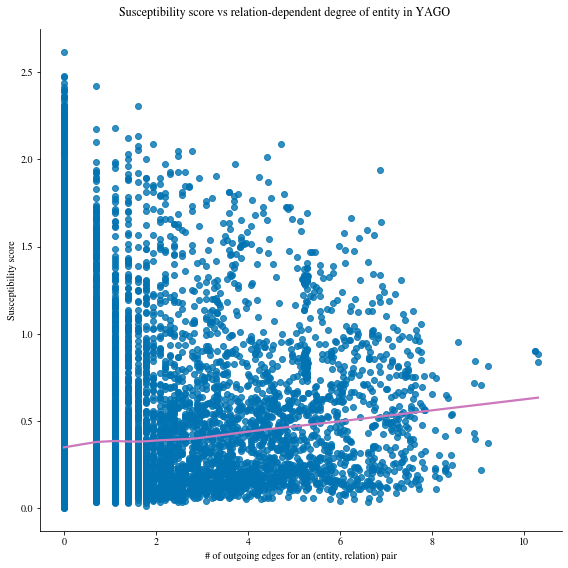

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.regplot(
    data=val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"],
    x="log_qid_ent_degree",
    y="susceptibility_score",
    # hue="query_type",
    lowess=True,
    line_kws={"color": palette[4]},
    ax=ax,
)
ax.set_xlabel("# of outgoing edges for an (entity, relation) pair")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility score vs relation-dependent degree of entity in YAGO")
plt.tight_layout()
ax.set_ylim
plot_name = f"plot_susscore_vs_yago_qid_degree_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

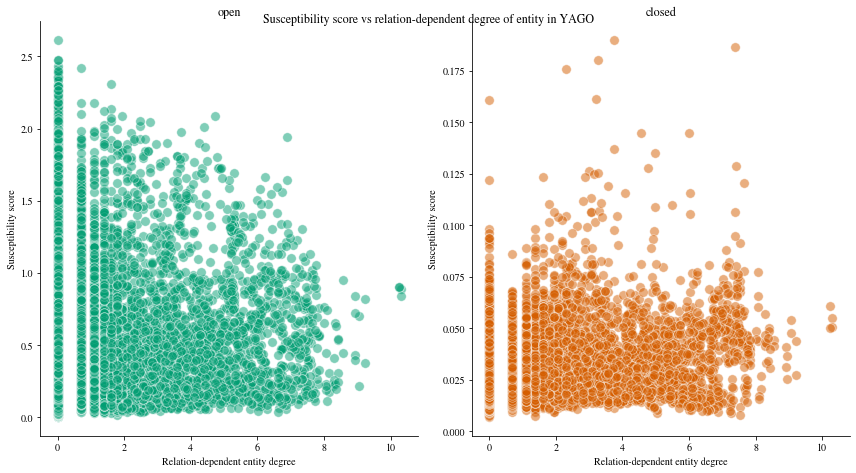

In [31]:
# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 90, "alpha": 0.5}

for i, qt in enumerate(reversed(val_dfs_with_deg["query_type"].unique())):
    ax = axes[i]
    sns.scatterplot(
        data=val_dfs_with_deg[val_dfs_with_deg["query_type"] == qt],
        x="log_qid_ent_degree",
        y="susceptibility_score",
        # hue="query_type",
        # size=10,
        # dodge=True,
        ax=ax,
        color=colormap[qt],
        legend=None,
        **scatter_kws,
    )
    ax.set_title(qt)
    ax.set_xlabel("Relation-dependent entity degree")
    ax.set_ylabel("Susceptibility score")
fig.suptitle(
    "Susceptibility score vs relation-dependent degree of entity in YAGO",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_susscore_vs_yago_qid_degree_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
# matplotlib.rcParams["font.size"] = "28"

### Susceptibility Score vs Entity Degree

In [32]:
### Entity degree (Query independent) ###
ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_degree.json"
with open(ENTITY_DEG_PATH) as f:
    entity_degree = json.load(f)

len(entity_degree)

96272

In [33]:
ent_degree_df = pd.DataFrame(
    [(ent_uri, deg) for ent_uri, deg in entity_degree.items()],
    columns=["entity_uri", "degree"],
)
ent_degree_df

,entity_uri,degree
0,http://yago-knowledge.org/resource/Paul_McCartney,894
1,http://yago-knowledge.org/resource/Paul_Allen_...,34
2,http://yago-knowledge.org/resource/Bicaz,90
3,http://yago-knowledge.org/resource/1992_Chines...,16
4,http://yago-knowledge.org/resource/Jane_Arthur,27
...,...,...
96267,http://yago-knowledge.org/resource/Republic_of...,40
96268,http://yago-knowledge.org/resource/Banda_do_Mar,24
96269,http://yago-knowledge.org/resource/Society_for...,473
96270,http://yago-knowledge.org/resource/Interstate_...,19


In [34]:
ENTITY_NAME_TO_URI_PATH = "data/YagoECQ/entity_name_to_possible_entity_uris.json"

with open(ENTITY_NAME_TO_URI_PATH) as f:
    entity_name_to_uri = json.load(f)
e_uri_to_name = {
    e_uri: entity_name
    for entity_name, e_uris in entity_name_to_uri.items()
    for e_uri in e_uris
}
len(e_uri_to_name)

ENTITY_URI_TO_NAME_PATH = "data/YagoECQ/entity_uri_to_name.json"
with open(ENTITY_URI_TO_NAME_PATH, "w", encoding="utf-8") as fp:
    json.dump(e_uri_to_name, fp, ensure_ascii=False, indent=4)

In [35]:
def convert_entity_uri_to_entity2(row: pd.Series):
    try:
        return e_uri_to_name[row["entity_uri"]]
    except (KeyError, ValueError):
        return None

In [36]:
ent_degree_df["entity"] = ent_degree_df.apply(convert_entity_uri_to_entity2, axis=1)
ent_degree_df = ent_degree_df.dropna()
ent_degree_df["entity"] = ent_degree_df["entity"].apply(lambda x: (x,))
ent_degree_df["degree"] = pd.to_numeric(ent_degree_df["degree"])
ent_degree_df

/scratch/tmp.51123313.kevidu/ipykernel_443266/2163315234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_degree_df["entity"] = ent_degree_df["entity"].apply(lambda x: (x,))
/scratch/tmp.51123313.kevidu/ipykernel_443266/2163315234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_degree_df["degree"] = pd.to_numeric(ent_degree_df["degree"])


,entity_uri,degree,entity
0,http://yago-knowledge.org/resource/Paul_McCartney,894,"(Paul McCartney,)"
1,http://yago-knowledge.org/resource/Paul_Allen_...,34,"(Paul Allen,)"
2,http://yago-knowledge.org/resource/Bicaz,90,"(Bicaz,)"
3,http://yago-knowledge.org/resource/1992_Chines...,16,"(Chinese Jia-A League 1992,)"
4,http://yago-knowledge.org/resource/Jane_Arthur,27,"(Jane Arthur,)"
...,...,...,...
96267,http://yago-knowledge.org/resource/Republic_of...,40,"(Republic of Tarnobrzeg,)"
96268,http://yago-knowledge.org/resource/Banda_do_Mar,24,"(Banda do Mar,)"
96269,http://yago-knowledge.org/resource/Society_for...,473,"(Society for Industrial and Applied Mathematics,)"
96270,http://yago-knowledge.org/resource/Interstate_...,19,"(Interstate 80 Business,)"


In [37]:
val_dfs_with_ent_deg = val_dfs_all.merge(ent_degree_df, on=["entity"])
val_dfs_with_ent_deg["log_degree"] = val_dfs_with_ent_deg["degree"].apply(np.log)
val_dfs_with_ent_deg

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,sampled_mr,sampled_answergroups,sampled_outputs,entity_classes,query_type,relevant_context_inds,entity_uri,degree,log_degree
0,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Christmas Carol' is about psychoanalysis.\...,"[0.1553642749786377, 0.22357654571533203, 0.12...","[0.027815370652517164, 0.043836283026991815, 0...",entities,0.043855,0.791583,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","["" Yes.\nQ: Is 'The Great G"", "" Yes.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[90, 91, 92, 93, 94]",http://yago-knowledge.org/resource/Crime_and_P...,89,4.488636
1,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Christmas Carol' is about psychoanalysis.\...,"[0.1553642749786377, 0.22357654571533203, 0.12...","[0.027815370652517164, 0.043836283026991815, 0...",entities,0.043855,0.791583,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","["" Yes.\nQ: Is 'The Great G"", "" Yes.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[90, 91, 92, 93, 94]",http://yago-knowledge.org/resource/Crime_and_P...,294,5.683580
2,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Christmas Carol' is about psychoanalysis.\...,"[0.1553642749786377, 0.22357654571533203, 0.12...","[0.027815370652517164, 0.043836283026991815, 0...",entities,0.043855,0.791583,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","["" Yes.\nQ: Is 'The Great G"", "" Yes.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[90, 91, 92, 93, 94]",http://yago-knowledge.org/resource/Crime_and_P...,57,4.043051
3,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Stranger Things,)",monster,['A Christmas Carol' is about psychoanalysis.\...,"[-0.06708741188049316, 0.09819746017456055, 0....","[0.022833921013827058, 0.04258298997236172, 0....",entities,0.038873,0.373494,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","["" Yes.\nQ: Is 'Stranger Things"", "" No.\nQ: Is...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[335, 336, 337, 338, 339]",http://yago-knowledge.org/resource/Stranger_Th...,264,5.575949
4,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,['A Christmas Carol' is about psychoanalysis.\...,"[0.03029918670654297, 0.14701223373413086, 0.0...","[0.015203277054757696, 0.03643121713720158, 0....",entities,0.030013,0.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","["" No.\nQ: Is 'The Wizard of"", "" No.\nQ: Is 'T...",{'http://schema.org/CreativeWork': 0.586206896...,closed,"[310, 311, 312, 313, 314]",http://yago-knowledge.org/resource/Sleeping_Be...,96,4.564348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25895,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,[Ambershade is the terminus of Interstate 26.\...,"[2.017101287841797, 2.215231418609619, 2.98624...","[1.184673030094263, 2.277884062687074, 2.10610...",entities,1.928297,0.000000,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",[' California State Route 113.\n\nReferences\n...,{'http://schema.org/Organization': 0.404761904...,open,"[145, 146, 147, 148, 149]",http://yago-knowledge.org/resource/Geneva,2531,7.836370
25896,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,[Ambershade is the terminus of Interstate 26.\...,"[2.017101287841797, 2.215231418609619, 2.98624...","[1.184673030094263, 2.277884062687074, 2.10610...",entities,1.928297,0.000000,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",[' California State Route 113.\n\nReferences\n...,{'http://schema.org/Organization': 0.404761904...,open,"[145, 146, 147, 148, 149]",http://yago-knowledge.org/resource

In [38]:
from scipy import stats as sst

sst.spearmanr(
    val_dfs_with_ent_deg[val_dfs_with_ent_deg["query_type"] == "open"][
        ["log_degree", "susceptibility_score"]
    ]
)

SpearmanrResult(correlation=-0.03040293887278103, pvalue=0.0005396509847841491)

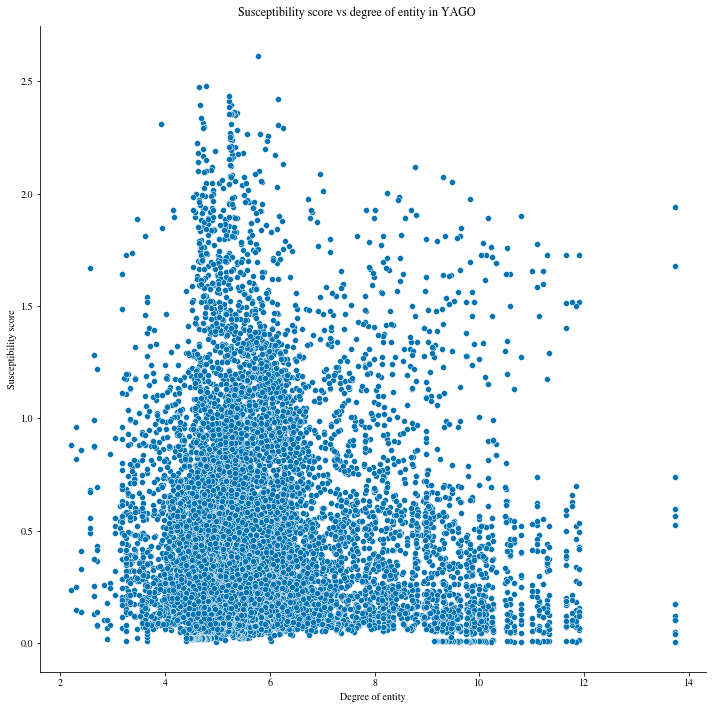

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.scatterplot(
    data=val_dfs_with_ent_deg[val_dfs_with_ent_deg["query_type"] == "open"],
    x="log_degree",
    y="susceptibility_score",
)
ax.set_xlabel("Degree of entity")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility score vs degree of entity in YAGO")
plt.tight_layout()
plot_name = f"plot_susscore_vs_yago_degree_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")